In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from game_tab import TicTacToe
import time


In [2]:
def visualize(board, board_size=3, players={0: '?', 1: 'X', 2: 'O'}):
    '''
    For fast visualization during debugging.
    Input:
    board <str>: Expected to be the board hash. Eg: '[1, 2, 1, 2, 1, 2, 1, 2, 1]'.
    board_size <int>: Default to be 3. If you are using a board with different size, remember to specify this.
    players <dict>: A dictionary for mapping numbers to symbols for better readability of the game board.
    '''
    for i, c in enumerate([int(x) for x in board[1:-1].split(',')]):
        if i % board_size == 0:
            print()
        print(players[c], end='\t')
    print()


class Environment(TicTacToe):
    def __init__(self, first_player=1, debug=False, **kwargs):
        '''
        Initialize the environment.
        Input:
        first_player <int>: Representing the starting player.
        debug <bool>: Default to False. If it was set to True, it will display debugging information.
        kwargs <dict>: A dictionary for holding keyword arguments being passed.
        '''
        self.first_player = first_player
        self.debug = debug
        self.kwargs = kwargs
        if self.kwargs == {}:
            super().__init__()             # Initializes the game
        else:
            super().__init__(self.kwargs)  # Initializes the game with keyword arguments

    @staticmethod
    def getHash(board):
        '''
        Get hash of the current board.
        Input:
        board <list>: A board which is of list type. Eg: [1, 2, 1, 2, 1, 2, 1, 2, 1].
        
        Return:
        <str>: The hash of the current state of the game.
        '''
        return str(board.tolist())

    def reset(self, first_player=None):
        '''
        For resetting the environment after the game has finished. Keyword arguments being passed during initialization of the environment will be passed again for re-initialization.
        Input:
        first_player <int>: Representing the starting player.
        
        Return:
        <str>: Hash of a board with only empty spaces.
        '''
        if self.kwargs == {}:
            super().__init__()             # Initializes the game
        else:
            super().__init__(self.kwargs)  # Initializes the game with keyword arguments
        if first_player is not None:
            self.player = first_player
        return self.getHash(self.board)

    def render(self):
        ''' Renders the current environment. '''
        self.visualize()

    def getAvailableMoves(self):
        ''' Get available moves of the current board. '''
        return np.where(self.board == self.EMPTY)[0]

    def action_space(self):
        ''' The action space of the current environment. A fancy wrap for consistency with Gym API. '''
        return self.getAvailableMoves()

    @staticmethod
    def getReward(state, maximized_player):
        '''
        Get the reward given the game state and the player to be maximized for his reward.
        Input:
        state <int>: The game state of the game. Possible values: -1: Tie game; 0: The game hasn't ended yet; 1: Player 1 won; 2: Player 2 won, ...
        maximized_player <int>: The player to be maximized for his reward.

        Return:
        <int>: Representing the reward in different situations.
        '''
        if state == -1:                  # No one wins
            return 0
        elif state == 0:                 # The game hasn't ended yet
            return 0
        elif state == maximized_player:  # The player which is to be maximized won
            return 1
        else:                            # Other players won
            return -1

    def step(self, action, player, maximized_player):
        '''
        Input:
        action <int>: The position of the move to be placed. It is 0-based, with range [0.. <board_size>].
        player <int>: The integer that represents the player. Eg 1 for player 1, 2 for player 2, ...
        maximized_player <int>: The player to be maximized for his reward.

        Return:
        observation <str>: The hash of the board before the move
        reward <int>: The reward due to the move
        game_state <int>: The game state of the game. Possible values: -1: Tie game; 0: The game hasn't ended yet; 1: Player 1 won; 2: Player 2 won, ...
        info <func>: For explaining the current situation of the game.
        '''
        if self.debug:
            print('Player:', player, 'Action:', action, 'Action space:', self.action_space())
        game_state = self.placeMove(action)
        observation = self.getHash(self.board)
        reward = self.getReward(game_state, maximized_player)
        if self.debug:
            print('Maximized Player:', maximized_player, 'Game State:', game_state, 'Reward:', reward, 'Observation:', observation)
            self.visualize()
            self.explain()
            input()
        info = self.explain
        return observation, reward, game_state, info

    def close(self):
        ''' For shutting down the environment. A fancy wrap for consistency with Gym API. '''
        self.game = None


class Agent:
    def __init__(self, debug=False):
        self.debug = debug
        pass

    def getAction(self, observation, action_space):
        '''
        To get action given the observation of the environment and the action space. As this is the most basic form of the agent, it will just return random actions.
        Input:
        observation <str>: The hash of the current state of the game.
        action_space <list>: A list of integers indicating available moves of the current state of the game.
        
        Return:
        action <int>: The move to be placed on the board.
        '''
        action = np.random.choice(action_space)
        return action

    def train(self, experience, f):
        ''' To train the agent. As this is the most basic form of the agent, it could not be trained. '''
        if self.debug:
            print('The agent is unable to learn.')
            input()
        pass


class QAgent(Agent):
    def __init__(self, discount_rate=0.9, learning_rate=1, epsilon=1, decay_rate=0.9999, debug=False):
        '''
        discount_rate <float>: To discount the reward if it takes more turns to get the reward. Eg if the reward is available after 2 turns, reward for the current move will be <reward> * discount_rate ** 2.
        learning_rate <float>: To specify the speed of learning from moves given rewards. Since this is a deterministic game, learning_rate could be set to 1.
        epsilon <float>: Representing the decay of trade-offs between exploration and exploitation.
        debug <bool>: Default to False. If it was set to True, it will display debugging information.
        '''
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.q_table = {}
        self.debug = debug

    @staticmethod
    def select_argmax(dictionary):
        '''
        Returns the move that maximizes the reward. If there are several moves with the maximum reward, it will randomly choose one in these moves.
        Input:
        dictionary <dict>: A dictionary that contains available moves and their corresponding rewards.
        
        Return:
        <int>: The action to be taken by the QAgent.
        '''
        if len(dictionary) == 0:
            raise ValueError('The length of the dictionary should not be zero!')
        max_q_value = max(dictionary.values())
        choices = []
        for key in dictionary:
            if dictionary[key] == max_q_value:
                choices.append(key)
        return np.random.choice(choices)

    @staticmethod
    def select_argmin(dictionary):
        '''
        Returns the move that minimizes the reward. If there are several moves with the minimum reward, it will randomly choose one in these moves.
        Input:
        dictionary <dict>: A dictionary that contains available moves and their corresponding rewards.
        
        Return:
        <int>: The exploitation (greedy) action to be taken by the QAgent.
        '''
        if len(dictionary) == 0:
            raise ValueError('The length of the dictionary should not be zero!')
        min_q_value = min(dictionary.values())
        choices = []
        for key in dictionary:
            if dictionary[key] == min_q_value:
                choices.append(key)
        return np.random.choice(choices)

    def getActionMax(self, observation, action_space):
        '''
        To get the action that maximizes the reward. It will be either an exploration or exploitation action, subject to the epsilon.
        Input:
        observation <str>: The hash of the current state of the game.
        action_space <list>: A list of integers indicating available moves of the current state of the game.
        
        Return:
        <int>: An action to be taken by the QAgent.
        '''
        action_random = super().getAction(observation, action_space)
        q_value_dict = {}
        for action in action_space:
            q_value_dict[action] = self.q_table.get(observation, {}).get(action, 0)
        action_greedy = self.select_argmax(q_value_dict)
        if self.debug:
            print('Action random:', action_random, 'Action greedy:', action_greedy)
        return action_random if np.random.random() < self.epsilon else action_greedy

    def getActionMin(self, observation, action_space):
        '''
        To get the action that minimizes the reward. It will be either an exploration or exploitation action, subject to the epsilon.
        Input:
        observation <str>: The hash of the current state of the game.
        action_space <list>: A list of integers indicating available moves of the current state of the game.
        
        Return:
        <int>: An action to be taken by the QAgent.
        '''
        action_random = super().getAction(observation, action_space)
        q_value_dict = {}
        for action in action_space:
            q_value_dict[action] = self.q_table.get(observation, {}).get(action, 0)
        action_greedy = self.select_argmin(q_value_dict)
        if self.debug:
            print('Action random:', action_random, 'action greedy:', action_greedy)
        return action_random if np.random.random() < self.epsilon else action_greedy

    def train(self, experience, f):
        '''
        To train the QAgent, given experience replay and a function representing whether to maximize or minimize the action.
        Input:
        experience <tuple>: The experiene replay of the game. It could be decomposed into five variables: observation, action, next_observation, reward, game_state.
        f <func>: A function representing whether to maximize or minimize the action of the player.
        
        Important variables:
        observation <str>: The hash of the board before the move
        action <int>: The position of the move to be placed. It is 0-based, with range [0.. <board_size>].
        next_observation <str>: The hash of the board after the move
        reward <int>: The reward due to the move
        game_state <int>: The game state of the game. Possible values: -1: Tie game; 0: The game hasn't ended yet; 1: Player 1 won; 2: Player 2 won, ...
        current_state_q_value: The Q-value of the current state. It is retrieved from the QAgent's Q-table.
        next_state_best_q_value: The predicted best Q-value of the next state. Since this is a minimax game, its objective is to minimize other players' rewards while maximizing self reward. It is retrieved from the QAgent's Q-table.
        '''
        observation, action, next_observation, reward, game_state = experience

        if self.q_table.get(observation) is None:         # Create a new entry for the q_table with the newly observed state
            self.q_table[observation] = {action: 0}       # Initialize the q_value of the action to 0

        if self.q_table[observation].get(action) is None: # What if such observation exists, but such action does not exist?
            self.q_table[observation][action] = 0         # Initialize the q_value of the action to 0

        if self.debug:
            print('observation:', observation)
            print('action:', action)
            print('self.q_table[observation]:', self.q_table[observation])
            print('current_state_q_value:', self.q_table[observation][action])
            print('next_state_best_q_value:', f(self.q_table.get(next_observation, {0: 0}).values()))

        next_state_best_q_value = f(self.q_table.get(next_observation, {0: 0}).values())
        current_state_q_value = self.q_table[observation][action]
        if current_state_q_value != 1:
            self.q_table[observation][action] = current_state_q_value + self.learning_rate * (reward + self.discount_rate * next_state_best_q_value - current_state_q_value)

        if self.debug:
            print(f'self.q_table[observation][action]: {self.q_table[observation][action]} = {current_state_q_value} + {self.learning_rate} * ({reward} + {self.discount_rate} * {next_state_best_q_value} - {current_state_q_value})')
            input()

        if game_state:
            self.epsilon *= self.decay_rate


def collect_statistics(stat, result):
    '''
    stat <list>: a list that stores the result of every game play.
    result <int>: the game state that indicates the result of the game.
    '''
    stat.append(result)
    return stat

# Training Random Agent vs Random Agent

In [3]:
env = Environment(debug=False)
random_agent = Agent(debug=False)
episode = 50000
stat = []

start_time = time.time()
for i_episode in range(episode):
    observation = env.reset()
    i = 0
    for t in range(100):
        player = env.getCurrentPlayer()
        if player == 1:
            action = random_agent.getAction(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
            random_agent.train(None, None)
        elif player == 2:
            action = random_agent.getAction(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
            random_agent.train(None, None)
        observation = next_observation
        if game_state != 0:
            stat = collect_statistics(stat, env.checkGameEnds())
            if (i_episode + 1) % 10000 == 0:
                print(f'Episode {i_episode + 1}, {time.time() - start_time:.2f}s elapsed')
                start_time = time.time()
            break
    env.close()

Episode 10000, 2.68s elapsed
Episode 20000, 2.72s elapsed
Episode 30000, 2.74s elapsed
Episode 40000, 2.75s elapsed
Episode 50000, 2.71s elapsed


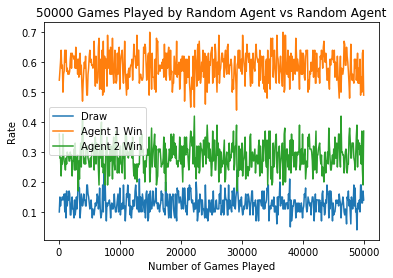

In [4]:
# First decode to three columns
summary = pd.get_dummies(stat)
draw = summary[-1]
agent_1 = summary[1]
agent_2 = summary[2]

# Then apply rolling(100).mean() to each of them
# Finally plot them out
interval = 100  # Take samples to calculate game outcomes per <interval>
plt.plot(draw.rolling(interval).mean()[::interval], label='Draw')
plt.plot(agent_1.rolling(interval).mean()[::interval], label='Agent 1 Win')
plt.plot(agent_2.rolling(interval).mean()[::interval], label='Agent 2 Win')
plt.legend()
plt.title(f'{episode} Games Played by Random Agent vs Random Agent')
plt.xlabel('Number of Games Played')
plt.ylabel('Rate')
plt.show()

# Testing Random Agent vs Random Agent

Episode 10000, 2.70s elapsed


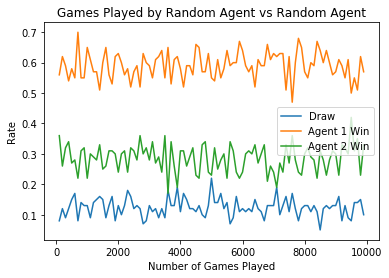

QAgent vs QAgent, for the past 10000 games:
Draw Rate        : 0.1241 (1241 Games)
Agent 1 Win Rate : 0.5909 (5909 Games)
Agent 2 Win Rate : 0.285 (2850 Games)


In [5]:
# Now we set epsilon to 0, to stop exploration and only retain expolitation.
# Let it play 10000 games we check the result of the game.
env.debug = False
random_agent.debug = False
episode = 10000
test_stat = []

start_time = time.time()
for i_episode in range(episode):
    first_player = 1
    observation = env.reset(first_player=first_player)
    i = 0
    for t in range(100):
        player = env.getCurrentPlayer()
        if player == 1:
            action = random_agent.getAction(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
        elif player == 2:
            action = random_agent.getAction(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
        observation = next_observation
        if game_state != 0:
            test_stat = collect_statistics(test_stat, env.checkGameEnds())
            if (i_episode + 1) % 10000 == 0:
                print(f'Episode {i_episode + 1}, {time.time() - start_time:.2f}s elapsed')
                start_time = time.time()
            break
    env.close()

# First decode to three columns
test_summary = pd.get_dummies(test_stat)
draw = test_summary.get(-1, pd.Series(index=test_stat, name=-1))
agent_1 = test_summary.get(1, pd.Series([0] * len(test_stat), name=1))
agent_2 = test_summary.get(2, pd.Series([0] * len(test_stat), name=2))

# Then apply rolling(100).mean() to each of them
# Finally plot them out
interval = 100  # Take samples to calculate game outcomes per <interval>
plt.plot(draw.rolling(interval).mean()[::interval], label='Draw')
plt.plot(agent_1.rolling(interval).mean()[::interval], label='Agent 1 Win')
plt.plot(agent_2.rolling(interval).mean()[::interval], label='Agent 2 Win')
plt.legend()
plt.title('Games Played by Random Agent vs Random Agent')
plt.xlabel('Number of Games Played')
plt.ylabel('Rate')
plt.show()

print(f'QAgent vs QAgent, for the past {episode} games:')
print(f'Draw Rate        : {draw.mean()} ({pd.Series(test_stat).value_counts().get(-1, 0)} Games)')
print(f'Agent 1 Win Rate : {agent_1.mean()} ({pd.Series(test_stat).value_counts().get(1, 0)} Games)')
print(f'Agent 2 Win Rate : {agent_2.mean()} ({pd.Series(test_stat).value_counts().get(2, 0)} Games)')

Now we know the random baseline of the game. A good agent should surpass the draw rate given by two random agents. Therefore, we should expect to have a higher draw rate or win rate after training.

# Training QAgent vs QAgent

In [6]:
episode = 100000
env = Environment(debug=False)
q_agent = QAgent(debug=False, decay_rate=0.001 ** (1 / episode))
stat = []

start_time = time.time()
for i_episode in range(episode):
    observation = env.reset()
    i = 0
    for t in range(100):
        player = env.getCurrentPlayer()
        if player == 1:
            action = q_agent.getActionMax(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
            q_agent.train((observation, action, next_observation, reward, game_state), min)
        elif player == 2:
            action = q_agent.getActionMin(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
            q_agent.train((observation, action, next_observation, reward, game_state), max)
        observation = next_observation
        if game_state != 0:
            stat = collect_statistics(stat, env.checkGameEnds())
            if (i_episode + 1) % 10000 == 0:
                print(f'Episode {i_episode + 1}, {time.time() - start_time:.2f}s elapsed')
                start_time = time.time()
            break
    env.close()

Episode 10000, 3.84s elapsed
Episode 20000, 4.00s elapsed
Episode 30000, 4.32s elapsed
Episode 40000, 4.55s elapsed
Episode 50000, 4.74s elapsed
Episode 60000, 4.86s elapsed
Episode 70000, 4.84s elapsed
Episode 80000, 4.91s elapsed
Episode 90000, 4.88s elapsed
Episode 100000, 4.95s elapsed


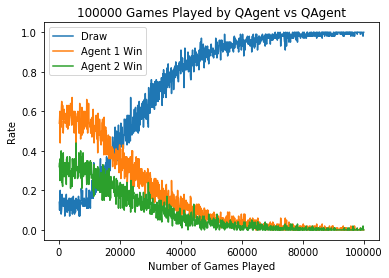

In [7]:
# First decode to three columns
summary = pd.get_dummies(stat)
draw = summary[-1]
agent_1 = summary[1]
agent_2 = summary[2]

# Then apply rolling(100).mean() to each of them
# Finally plot them out
interval = 100  # Take samples to calculate game outcomes per <interval>
plt.plot(draw.rolling(interval).mean()[::interval], label='Draw')
plt.plot(agent_1.rolling(interval).mean()[::interval], label='Agent 1 Win')
plt.plot(agent_2.rolling(interval).mean()[::interval], label='Agent 2 Win')
plt.legend()
plt.title(f'{episode} Games Played by QAgent vs QAgent')
plt.xlabel('Number of Games Played')
plt.ylabel('Rate')
plt.show()

# Testing QAgent vs QAgent

Episode 10000, 4.67s elapsed
Episode 20000, 4.67s elapsed
Episode 30000, 4.66s elapsed
Episode 40000, 4.68s elapsed
Episode 50000, 4.65s elapsed


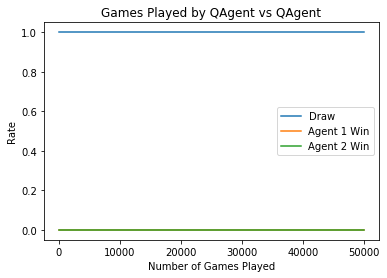

QAgent vs QAgent, for the past 50000 games:
Draw Rate        : 1.0 (50000 Games)
Agent 1 Win Rate : 0.0 (0 Games)
Agent 2 Win Rate : 0.0 (0 Games)


In [8]:
# Now we set epsilon to 0, to stop exploration and only retain expolitation.
# Let it play 10000 games we check the result of the game.

q_agent.epsilon = 0
episode = 50000
test_stat = []

start_time = time.time()
for i_episode in range(episode):
    observation = env.reset()
    i = 0
    for t in range(100):
        player = env.getCurrentPlayer()
        if player == first_player:
            action = q_agent.getActionMax(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
        else:
            action = q_agent.getActionMin(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
        observation = next_observation
        if game_state != 0:
            test_stat = collect_statistics(test_stat, env.checkGameEnds())
            if (i_episode + 1) % 10000 == 0:
                print(f'Episode {i_episode + 1}, {time.time() - start_time:.2f}s elapsed')
                start_time = time.time()
            break
    env.close()

# First decode gameplay results to three columns
test_summary = pd.get_dummies(test_stat)
draw = test_summary.get(-1, pd.Series(index=test_stat, name=-1))
agent_1 = test_summary.get(1, pd.Series([0] * len(test_stat), name=1))
agent_2 = test_summary.get(2, pd.Series([0] * len(test_stat), name=2))

# Then apply rolling(100).mean() to each of them to calculate average draw or win rate per 100 intervals
# Finally plot them out
interval = 100  # Take samples to calculate game outcomes per <interval>
plt.plot(draw.rolling(interval).mean()[::interval], label='Draw')
plt.plot(agent_1.rolling(interval).mean()[::interval], label='Agent 1 Win')
plt.plot(agent_2.rolling(interval).mean()[::interval], label='Agent 2 Win')
plt.legend()
plt.title('Games Played by QAgent vs QAgent')
plt.xlabel('Number of Games Played')
plt.ylabel('Rate')
plt.show()

print(f'QAgent vs QAgent, for the past {episode} games:')
print(f'Draw Rate        : {draw.mean()} ({pd.Series(test_stat).value_counts().get(-1, 0)} Games)')
print(f'Agent 1 Win Rate : {agent_1.mean()} ({pd.Series(test_stat).value_counts().get(1, 0)} Games)')
print(f'Agent 2 Win Rate : {agent_2.mean()} ({pd.Series(test_stat).value_counts().get(2, 0)} Games)')

In [9]:
len(q_agent.q_table)

4519

In [10]:
import pickle as pk
f = open('q_table', 'wb')

pk.dump(q_agent.q_table, f)

# Test Cases

To make sure the agent works perfectly in different situations, we should write test cases and test them.

In [11]:
board = '[1, 1, 0, 2, 2, 0, 1, 2, 1]'
visualize(board)
print(q_agent.q_table[board])
if q_agent.q_table[board][2] > q_agent.q_table[board][5]:
    print('OK')
else:
    print('Failed, position 2 should have greater q value than position 5.')


XX?
OO?
XOX
{5: -1.0, 2: 0.0}
OK


In [12]:
board = '[1, 0, 0, 2, 2, 1, 1, 2, 1]'
visualize(board)
print(q_agent.q_table[board])

if q_agent.q_table[board][1] < q_agent.q_table[board][2]:
    print('OK')
else:
    print('Failed, position 1 should have smaller q value than position 2.')


X??
OOX
XOX
{2: 0.0, 1: -1.0}
OK


In [13]:
board = '[1, 0, 0, 2, 2, 0, 1, 2, 1]'
visualize(board)
print(q_agent.q_table[board])
if q_agent.q_table[board][1] == q_agent.q_table[board][5]:
    print('OK')
else:
    print('Failed, position 1 should have the same q value with position 5.')

if q_agent.q_table[board][1] != q_agent.q_table[board][2] and q_agent.q_table[board][5] != q_agent.q_table[board][2]:
    print('OK')
else:
    print('Failed, position 1 and position 5 should have more negative q value when compared with position 2.')


X??
OO?
XOX
{2: -0.9, 1: -0.9, 5: -0.9}
OK
Failed, position 1 and position 5 should have more negative q value when compared with position 2.


From the above case, we found that when the computer thinks that it will lose anyway, it will just give up and treat these positions indifferently.

In [14]:
board = '[1, 0, 0, 0, 1, 0, 2, 0, 0]'
visualize(board)
print(q_agent.q_table[board])
if q_agent.q_table[board][8] == min(q_agent.q_table[board].values()):
    print('OK')
else:
    print('Failed, position 8 should have the smallest q value.')


X??
?X?
O??
{7: 0.9, 2: 0.9, 8: 0.0, 1: 0.9, 5: 0.9, 3: 0.9}
OK


In [15]:
board = '[2, 0, 2, 0, 1, 0, 1, 1, 0]'
visualize(board)
print(q_agent.q_table[board])
if q_agent.q_table[board][1] == min(q_agent.q_table[board].values()):
    print('OK')
else:
    print('Failed, position 1 should have the smallest q value.')


O?O
?X?
XX?
{5: 0.9, 1: -1.0, 8: 0.9}
OK


In [16]:
board = '[0, 0, 2, 1, 0, 2, 0, 1, 0]'
visualize(board)
print(q_agent.q_table[board])
if q_agent.q_table[board][8] == max(q_agent.q_table[board].values()):
    print('OK')
else:
    print('Failed, position 8 should have either the largest q value.')


??O
X?O
?X?
{8: 0.6561000000000001, 0: -0.9000000000000001, 4: -0.9, 1: -0.7290000000000001}
OK


How about QAgent vs Random Agent? Does QAgent always superior to Random Agent?

# Testing QAgent vs Random Agent

Episode 10000, 2.60s elapsed


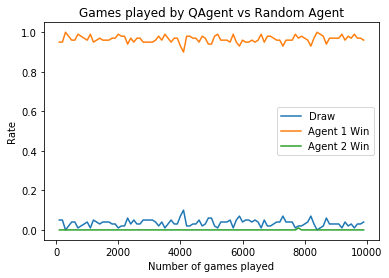

QAgent vs QAgent, for the past 10000 games:
Draw Rate        : 0.0348 (348 Games)
Agent 1 Win Rate : 0.9651 (9651 Games)
Agent 2 Win Rate : 0.0001 (1 Games)


In [17]:
# Now we set epsilon to 0, to stop exploration and only retain expolitation.
# Let it play 10000 games we check the result of the game.

q_agent.epsilon = 0
episode = 10000
test_stat = []

start_time = time.time()
for i_episode in range(episode):
    observation = env.reset()
    history = []
    history.append(observation)
    i = 0
    for t in range(100):
        player = env.getCurrentPlayer()
        if player == 1:
            if first_player == 1:
                action = q_agent.getActionMax(observation, env.getAvailableMoves())
            else:
                action = q_agent.getActionMin(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
        elif player == 2:
            action = random_agent.getAction(observation, env.getAvailableMoves())
            next_observation, reward, game_state, info = env.step(action, player, 1)
        observation = next_observation
        history.append(observation)
        if game_state != 0:
            test_stat = collect_statistics(test_stat, env.checkGameEnds())
            if (i_episode + 1) % 10000 == 0:
                print(f'Episode {i_episode + 1}, {time.time() - start_time:.2f}s elapsed')
                start_time = time.time()
            break
    env.close()

# First decode to three columns
test_summary = pd.get_dummies(test_stat)
draw = test_summary.get(-1, pd.Series(index=test_stat, name=-1))
agent_1 = test_summary.get(1, pd.Series([0] * len(test_stat), name=1))
agent_2 = test_summary.get(2, pd.Series([0] * len(test_stat), name=2))

# Then apply rolling(100).mean() to each of them
# Finally plot them out
interval = 100  # Take samples to calculate game outcomes per <interval>
plt.plot(draw.rolling(interval).mean()[::interval], label='Draw')
plt.plot(agent_1.rolling(interval).mean()[::interval], label='Agent 1 Win')
plt.plot(agent_2.rolling(interval).mean()[::interval], label='Agent 2 Win')
plt.legend()
plt.title('Games played by QAgent vs Random Agent')
plt.xlabel('Number of games played')
plt.ylabel('Rate')
plt.show()

print(f'QAgent vs QAgent, for the past {episode} games:')
print(f'Draw Rate        : {draw.mean()} ({pd.Series(test_stat).value_counts().get(-1, 0)} Games)')
print(f'Agent 1 Win Rate : {agent_1.mean()} ({pd.Series(test_stat).value_counts().get(1, 0)} Games)')
print(f'Agent 2 Win Rate : {agent_2.mean()} ({pd.Series(test_stat).value_counts().get(2, 0)} Games)')

## Let's play some games with our QAgent!

In [18]:
answer = input('Would you like to start first? Enter anything to start as the first player, or just press <Enter> to become the second player: ')
if answer != '':
    HUMAN_PLAYER = 1
    COMPUTER_PLAYER = 2
    first_player = HUMAN_PLAYER
else:
    COMPUTER_PLAYER = 1
    HUMAN_PLAYER = 2
    first_player = COMPUTER_PLAYER

observation = env.reset(first_player=first_player)
q_agent.epsilon = 0
env.render()
i = 0
for t in range(100):
    player = env.getCurrentPlayer()
    if player == HUMAN_PLAYER:
        action = int(input(f'Human\'s move (0 to {env.board_size ** 2 - 1}): '))
    elif player == COMPUTER_PLAYER:
        if first_player == COMPUTER_PLAYER:
            action = q_agent.getActionMax(observation, env.getAvailableMoves())
        else:
            action = q_agent.getActionMin(observation, env.getAvailableMoves())
        print(f'QAgent\'s move (0 to {env.board_size ** 2 - 1}): {action}')
    next_observation, reward, done, info = env.step(action, player, True)
    observation = next_observation
    reward += reward
    env.render()
    if done:
        break
#         sleep(2)
#     clear_output(wait=True)
env.explain()
env.close()

Round 1:
???
???
???
QAgent's move (0 to 8): 2
Round 2:
??X
???
???
Round 3:
O?X
???
???
QAgent's move (0 to 8): 6
Round 4:
O?X
???
X??


ValueError: invalid literal for int() with base 10: ''

# Future Directions